# 【例題2.8】

## (5) 特性曲線法による洪水流の図解法

- 特性曲線法により水深の経時変化から流量ハイドログラフを作成するプログラムです．

- 計算条件は，エクセルファイル”InputData2_8_5.xlsx”をご確認ください．
    - 計算条件の設定は，"計算条件"のシートで行います．
    - 水深の経時変化の設定は，"水深の経時変化"のシートで行います．

- 流量の経時変化が，"MCRes.xlsx"に出力されます．


In [1]:
'''特性曲線法により水深の経時変化から流量ハイドログラフを作成するプログラム'''
# !/usr/bin/env python3
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize
# 定数の設定
GRAVITY_ACCELERATION: float = 9.81  # 重力加速度
SHEET1_NAME = "計算条件"  # 入力データのシート名
SHEET2_NAME = "水深の経時変化"  # 入力データのシート名
INPUT_FILE_NAME = 'inputData2_8_5.xlsx'  # 入力条件のファイル名
OUT_PUT_FILEANME = 'MCRes.xlsx'
EPS = 1e-15

## データの読み込むクラス

In [2]:
class SetData:
    """データを読み込むクラス"""
    def __init__(self):
        self.data = pd.read_excel(INPUT_FILE_NAME, sheet_name=None)
        # 計算条件の読み込み
        print(self.data[SHEET1_NAME])
        __colName = self.data[SHEET1_NAME].columns
        self.Ib = self.data[SHEET1_NAME][__colName[1]][0]
        self.n = self.data[SHEET1_NAME][__colName[1]][1]
        self.B = self.data[SHEET1_NAME][__colName[1]][2]
        self.dx = self.data[SHEET1_NAME][__colName[1]][3]
        self.TC_COEFF = self.data[SHEET1_NAME][__colName[1]][4]
        # 水深の時系列の確認
        print(self.data[SHEET2_NAME])
        __colName = self.data[SHEET2_NAME].columns
        self.t = np.array(self.data[SHEET2_NAME][__colName[0]])  # 時刻
        self.h = np.array(self.data[SHEET2_NAME][__colName[1]])  # 水深
        self.TimeNo = len(self.h)
        # 他のパラメータの確保
        self.tC = [[] for i in range(self.TimeNo)]
        self.U = [[] for i in range(self.TimeNo)]
        self.C = [[] for i in range(self.TimeNo)]
        self.xC = [[] for i in range(self.TimeNo)]
        self.ts = self.t*self.TC_COEFF  # sec単位に変換
        # 結果をストアする行列を生成
        self.tRes = []
        self.hRes = []
        self.CRes = []
        self.URes = []
        self.QRes = []

## 特性曲線法の図解法のクラス

### $x$=0の等流時の流速$U$と波速$C$の計算

$U_0 = \frac{1}{n}R_0I_b$

$C_0 = \sqrt{gh_0}$

ここに下添字，0は等流時の値であることを示す．

### 計算に用いる式

$I_f = \frac{n^2U^2}{R^{4/3}}$

$K=\frac{g}{2}(I_b-I_f)$

$\Delta{x_u} = (U_u+C_u+U+C)\Delta t/2$

$\Delta{x_d} = (U_d-C_d+U-C)\Delta t/2$

$\Delta {x} = \Delta{x_u}-\Delta{x_d} = (2C+U_u-U_d+C_u+C_d)\Delta t /2$

$\Delta t = \frac{2\Delta x}{2C+U_u-U_d+C_u+C_d}$

$C= -\frac{1}{8}\left(U_u-U_d\right)+\frac{1}{2}\sqrt{\left \{\frac{3}{4}(U_u-U_d)+(C_u+C_d)\right \}^2+\Delta x(K_u-K_d)}$

$U = \frac{R^{4/3}}{gn^2 \Delta t}\left[ -1+\sqrt{1+\frac{2gn^2}{R^{4/3}}\Delta t\left \{ U_d+2(C-C_d)+(\frac{gI_b}{2}+K_d)\Delta t\right \}}\right]$

In [3]:
class MethodOfCharacteristics(SetData):
    """特性曲線法の図解法のクラス"""
    def __init__(self):
        # 変数等の設定
        super().__init__()

    # 流積A
    def __calcA(self, _h):
        return(self.B*_h)

    # 潤辺
    def __calc_s(self, _h):
        return(self.B+2.*_h)

    # 径深
    def __calcR(self, _A, _s):
        return(_A/_s)

    # 等流の流速
    def __calcU0(self, _R):
        return(1./self.n*_R**(2./3.)*self.Ib**.5)

    # 波速
    def __calcC(self, _h):
        return((GRAVITY_ACCELERATION*_h)**.5)

    # 摩擦勾配
    def __calcIf(self, _U, _R):
        return(self.n**2.*_U**2./_R**(4./3.))

    # 波速から水深へ
    def __Ctoh(self, _C):
        return(_C**2./GRAVITY_ACCELERATION)

    # 波速から水深と径水
    def __CtohR(self, _C):
        __h = self.__Ctoh(_C)
        __A = self.__calcA(__h)
        __s = self.__calc_s(__h)
        __R = self.__calcR(__A, __s)
        return(__h, __R)

    # K = g(Ib-If)/2
    def __calcK(self, _If):
        return(GRAVITY_ACCELERATION*(self.Ib-_If)/2.)

    # Uの算定
    def __calcUx(self, _R, _Rd, _C, _Ud, _Cd, _dt):
        __Ifd = self.__calcIf(_Ud, _Rd)
        __Kd = self.__calcK(__Ifd)
        __U = (_R**(4./3.)/(GRAVITY_ACCELERATION*self.n**2.*_dt) *
               (-1.+np.sqrt(1.+2.*GRAVITY_ACCELERATION*self.n**2./_R**(4./3.) *
                            _dt*(_Ud+2.*(_C-_Cd)+(GRAVITY_ACCELERATION *
                                                  self.Ib/2.+__Kd)*_dt))))
        return(__U)

    # t=0 x=200mの結果
    def __setInitRes(self):
        self.tRes.append(0.0)
        self.hRes.append(self.h[0])
        self.URes.append(self.U[0][0])
        self.CRes.append(self.C[0][0])
        self.QRes.append(self.__calcA(self.h[0])*self.U[0][0])

    # t=0の特性速度，x~t, U~t,C~tの関係
    def __setXUC_t0(self):
        self.tC[0].append(self.t[-1])
        self.C[0].append(self.C[0][0])
        self.U[0].append(self.U[0][0])
        self.xC[0] = (np.array(self.C[0]) +
                      np.array(self.U[0]))*(np.array(self.tC[0]) -
                                            self.tC[0][0])*self.TC_COEFF
        __tRes = self.tC[0][0]+(self.tC[0][1] -
                                self.tC[0][0])/(self.xC[0][1] -
                                                self.xC[0][0])*self.dx
        __hRes = (self.C[0][0])**2./GRAVITY_ACCELERATION
        __URes = self.U[0][0]
        __CRes = self.C[0][0]
        self.tRes.append(__tRes)
        self.hRes.append(__hRes)
        self.CRes.append(__CRes)
        self.URes.append(__URes)
        self.QRes.append(self.__calcA(__hRes)*__URes)

    # 線形補間の関数
    def __interpolate(self, _y0, _yP, _t0, _tP, _dt):
        return(_y0+(_yP-_y0)/(_tP-_t0)*_dt)

    # UとCを線形補間で求める関数
    def __setUC(self, _tM, _CM, _UM, _dts, _dt, _i):
        _Cd = self.__interpolate(_CM[_i-1], _CM[_i],
                                 _tM[_i-1], _tM[_i], _dts-_dt)
        _Ud = self.__interpolate(_UM[_i-1], _UM[_i],
                                 _tM[_i-1], _tM[_i], _dts-_dt)
        return(_Cd, _Ud)

    # Uの推定
    def __calcTmpU(self, _dt, _t, _C, _tM, _CM, _UM, _dts):
        (__h, __R) = self.__CtohR(_C)
        __i = np.where(_tM >= _t)[0][0]
        (__Cd, __Ud) = self.__setUC(_tM, _CM, _UM, _dts, _dt, __i)
        (__hd, __Rd) = self.__CtohR(__Cd)
        __U = self.__calcUx(__R, __Rd, _C, __Ud, __Cd, _dt*self.TC_COEFF)
        return(__U, __Ud, __Cd)

    # dxの推定
    def __calc_dtd(self, _dt, _t, _C, _tM, _CM, _UM, _dts):
        (__U, __Ud, __Cd) = self.__calcTmpU(_dt, _t, _C, _tM, _CM, _UM, _dts)
        __dxd1 = np.abs(__Ud-__Cd+__U-_C)*_dt/2.
        __dxd2 = (__Ud+__Cd)*(_dts-_dt)
        return(np.abs(__dxd1-__dxd2))

    # 境界でのUを推定する関数
    def __procUx0(self, _t, _C, _tM, _CM, _UM, _dts):
        __dT = scipy.optimize.fmin(self.__calc_dtd, x0=[_dts/2.],
                                   xtol=EPS, disp=False,
                                   args=(_t, _C, _tM, _CM, _UM, _dts, ))[0]
        # print(_dts-__dT)
        __U = self.__calcTmpU(__dT, _t, _C, _tM, _CM, _UM, _dts)[0]
        return(__U)

    # UとCを計算する関数
    def __calc_dxUdCd(self, _t, _C, _tM, _CM, _UM, _xC, _xCM):
        __i = np.where(_tM >= _t)[0][0]
        __dt = _t-_tM[__i-1]
        __dx = self.__interpolate(_xCM[__i-1], _xCM[__i],
                                  _tM[__i-1], _tM[__i], __dt)-_xC[-1]
        __U = self.__interpolate(_UM[__i-1], _UM[__i],
                                 _tM[__i-1], _tM[__i], __dt)
        __C = self.__interpolate(_CM[__i-1], _CM[__i],
                                 _tM[__i-1], _tM[__i], __dt)
        return(__dx, __U, __C)

    # 特性曲線
    def __calc_CUdT(self, _Uu, _Ud, _Cu, _Cd, _dx):
        (__hu, __Ru) = self.__CtohR(_Cu)
        (__hd, __Rd) = self.__CtohR(_Cd)
        __Ifu = self.__calcIf(_Uu, __Ru)
        __Ifd = self.__calcIf(_Ud, __Rd)
        __Ku = self.__calcK(__Ifu)
        __Kd = self.__calcK(__Ifd)
        __dU = _Uu-_Ud
        __C = -1./8.*__dU+1./2.*np.sqrt((3./4.*__dU +
                                         (_Cu+_Cd))**2.+_dx*(__Ku-__Kd))
        __dT = 2.*_dx/(2.*__C+__dU+_Cu+_Cd)
        (__h, __R) = self.__CtohR(__C)
        __U = self.__calcUx(__R, __Rd, __C, _Ud, _Cd, __dT)
        __dxu = (_Uu+_Cu+__U+__C)*__dT/2.0
        return(__C, __U, __dT/self.TC_COEFF, __dxu)

    # x＝200mの計算結果
    def __getRes(self, _xC, _U, _C, _tC):
        __i = np.where(_xC >= self.dx)[0][0]
        __dx = self.dx-_xC[__i-1]
        __resU = self.__interpolate(_U[__i-1], _U[__i],
                                    _xC[__i-1], _xC[__i], __dx)
        __resC = self.__interpolate(_C[__i-1], _C[__i],
                                    _xC[__i-1], _xC[__i], __dx)
        __restC = self.__interpolate(_tC[__i-1], _tC[__i],
                                     _xC[__i-1], _xC[__i], __dx)
        __resh = self.__Ctoh(__resC)
        return(__restC, __resU, __resC, __resh)

    # t!0の特性速度，x~t, U~t,C~tの関係
    def __setXUC_t(self, i):
        # x=0mのUの計算
        __t = self.t[i]
        __C = self.C[i][0]
        __tM = np.array(self.tC[i-1])
        __CM = np.array(self.C[i-1])
        __UM = np.array(self.U[i-1])
        __U = self.__procUx0(__t, __C, __tM, __CM, __UM, __t-self.t[i-1])
        #
        self.U[i].append(__U)
        self.xC[i].append(0.0)
        # x mのUとCの計算
        __tmpT = __t
        while(1):
            # dxの計算
            (__dx, __Ud, __Cd) = self.__calc_dxUdCd(__tmpT, __C, __tM,
                                                    __CM, __UM,
                                                    self.xC[i], self.xC[i-1])
            (__tmpC, __tmpU, __dT, __dxu) = self.__calc_CUdT(self.U[i][-1],
                                                             __Ud,
                                                             self.C[i][-1],
                                                             __Cd, __dx)
            self.xC[i].append(self.xC[i][-1]+__dxu)
            self.U[i].append(__tmpU)
            self.C[i].append(__tmpC)
            self.tC[i].append(self.tC[i][-1]+__dT)
            __tmpT += __dT
            if(__tmpT > self.t[-1]):
                break
        # 結果の保存
        if(np.max(self.xC[i]) > self.dx):
            __res = self.__getRes(np.array(self.xC[i]),
                                  np.array(self.U[i]),
                                  np.array(self.C[i]),
                                  np.array(self.tC[i]))
            self.tRes.append(__res[0])
            self.CRes.append(__res[2])
            self.hRes.append(__res[3])
            self.URes.append(__res[1])
            self.QRes.append(self.__calcA(__res[3])*__res[1])

    # 特性曲線法の計算手順
    def procMC(self):
        # 流積
        self.A = self.__calcA(self.h)
        # 潤辺
        self.s = self.__calc_s(self.h)
        # 径深
        self.R = self.__calcR(self.A, self.s)
        # 境界条件の設定 (x=0のCの経時変化)
        for i in range(self.TimeNo):
            self.tC[i].append(self.t[i])
            self.C[i].append(self.__calcC(self.h[i]))
        # t=0のUの推定
        self.U[0].append(self.__calcU0(self.R[0]))
        # t=0の計算結果を保存
        self.__setInitRes()
        # t=0の特性速度，x~t, U~t,C~tの関係
        self.__setXUC_t0()
        # t!=0の特性速度，x~t, U~t,C~tの関係とx＝10kmでの時刻と計算結果
        for i in range(1, self.TimeNo-1):
            self.__setXUC_t(i)

    # 図の出力
    def plot(self):
        cl = 'black'
        cl2 = 'gray'
        cl3 = 'white'
        X_RANGE = [0.0, 4.0*self.dx]
        Y_RANGE = [np.min(self.t), np.max(self.t)]
        __label = '$x$='+str(int(self.dx))+'m'
        if(self.TC_COEFF == 1.0):
            __tlabel = '$t$(s)'
        elif(self.TC_COEFF == 60.0):
            __tlabel = '$t$(min)'
        elif(self.TC_COEFF == 3600.0):
            __tlabel = '$t$(hr)'
        else:
            print("ERROR!")
            exit()

        __C0 = []
        __U0 = []
        __t0 = []
        fig, axes = plt.subplots(1, 3, figsize=(10, 5), tight_layout=True)
        for i in range(self.TimeNo):
            __C0.append(self.C[i][0])

        for i in range(self.TimeNo-1):
            __lambda = np.array(self.U[i])+np.array(self.C[i])
            axes[0].plot(__lambda*(self.tC[i]-self.t[i])*self.TC_COEFF,
                         self.tC[i], '-', color=cl)
            __t0.append(self.t[i])
            __U0.append(self.U[i][0])
            axes[1].plot(self.C[i], self.tC[i], '-', color=cl)
            axes[2].plot(self.U[i], self.tC[i], '-', color=cl)
        __Q0 = __U0*self.__calcA(self.h[:-1])

        axes[1].plot(__C0, self.t, 'o-', color=cl2)
        axes[2].plot(__U0, __t0, 'o', color=cl2)
        # 0の値
        axes[1].plot(self.C[0], self.tC[0], color=cl)
        axes[2].plot(self.U[0], self.tC[0], color=cl)
        # 流量推定地点
        axes[0].plot([self.dx, self.dx], [self.t[0], self.t[-1]], '--',
                     color=cl)
        # x=deltaxの値
        axes[0].plot([self.dx]*(len(self.tRes[1:])), self.tRes[1:], 'o',
                     color=cl, markerfacecolor=cl3)
        axes[1].plot(self.CRes[1:], self.tRes[1:], '--o',
                     color=cl, markerfacecolor=cl3)
        axes[2].plot(self.URes[1:], self.tRes[1:], '--o',
                     color=cl, markerfacecolor=cl3)
        # x軸のラベル
        axes[0].set_xlim(X_RANGE)
        axes[0].set_xlabel('$x$(m)')
        axes[1].set_xlabel('$C$(m/s)')
        axes[2].set_xlabel('$U$(m/s)')
        for i in range(3):
            axes[i].set_ylim(Y_RANGE)
            axes[i].set_ylabel(__tlabel)
            axes[i].grid()
        plt.savefig('MC.pdf', transparent=True, bbox_inches='tight')

        # 水深・流量の経時変化
        # 水深の経時変化
        fig, axes = plt.subplots(1, 2, figsize=(10, 2.5), tight_layout=True)
        axes[0].plot(self.t, self.h, '-o', color=cl, label='$x$=0m')
        axes[0].plot(self.tRes, self.hRes, '-o', color=cl2, label=__label)
        axes[0].set_xlim(self.t[0], self.t[-2])
        axes[0].set_xlabel(__tlabel)
        axes[0].set_ylabel('$h$ (m)')
        axes[0].legend(fontsize=10, fancybox=False, framealpha=1)
        axes[0].grid()
        # 流量の経時変化
        axes[1].plot(__t0, __Q0, '-o', color=cl, label='$x$=0m')
        axes[1].plot(self.tRes, self.QRes, '-o', color=cl2, label=__label)
        axes[1].set_xlim(self.t[0], self.t[-2])
        axes[1].set_xlabel(__tlabel)
        axes[1].set_ylabel('$Q$ (m$^3$/s)')
        axes[1].legend(fontsize=10, fancybox=False, framealpha=1)
        axes[1].grid()
        plt.savefig('Timeh_Q.pdf', transparent=True, bbox_inches='tight')

    # ファイルの出力
    def writeFile(self):
        # データフレームの作成
        __df = pd.DataFrame(self.tRes, columns=['t(hr)'])
        __df['h(m)'] = self.hRes
        __df['Q(m3/s)'] = self.QRes
        __df.to_excel(OUT_PUT_FILEANME)

# main関数

                            変数名          数値
0                        河床勾配Ib      0.0004
1                粗度係数n(m-1/3・s)      0.0300
2                        川幅B(m)    300.0000
3                水深算出地点までの距離(m)  10000.0000
4  時間の補正係数(hr :3600,min:60,s:1)   3600.0000
    時刻(hr)  水深h(m)
0        0    1.53
1        1    1.81
2        2    2.01
3        3    2.26
4        4    3.56
5        5    4.25
6        6    4.79
7        7    4.34
8        8    4.00
9        9    3.56
10      10    3.19
11      11    2.88
12      12    2.50


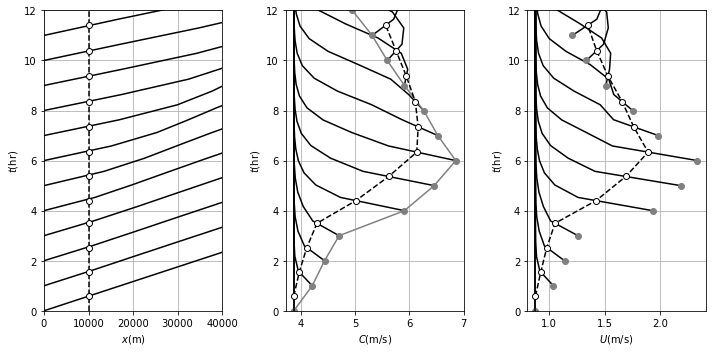

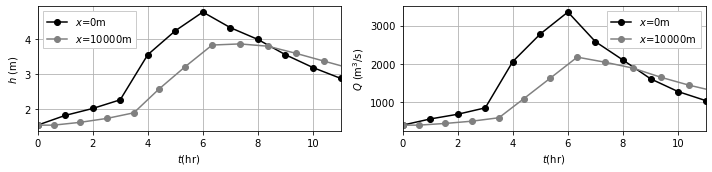

In [4]:
if __name__ == "__main__":
    """main関数"""
    # 特性曲線法のインスタンス
    MC = MethodOfCharacteristics()
    MC.procMC()
    MC.plot()
    MC.writeFile()
    del MC